In [3]:
# Copyright 2023 Andrew Lehr
# The MIT LICENSE

# Dynamic control of neural manifolds
#### Lehr, Kumar, & Tetzlaff

####
### Code to produce Figure 6 (except j,k)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import contour

from collections import defaultdict
import itertools
import copy

import os.path as path
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom

from submanifolds.utils import get_root
from submanifolds.ringnet.network import RingNetworkVariableSpeed
from submanifolds.ringnet import Parameters
from submanifolds.ringnet import Plot
from submanifolds.utils import get_root

### Color palettes

In [2]:
colors = ['#586ba4', '#f68e5f', '#f5dd90',  
          '#067d7a', '#77c1b3',  '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

### Directories

In [3]:
root = get_root()
save_figs_flag = 0

# Figure storage
fig_top_dir = root + 'figures/'
fig_dir = fig_top_dir + 'figure_6/'

# Data storage
data_top_dir = root + 'data/'
data_dir = data_top_dir + 'simulaneous_control/'

if not os.path.isdir(fig_top_dir):
    os.mkdir(fig_top_dir)
    print('Created ' + fig_top_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('fig dir exists')

if not os.path.isdir(data_top_dir):
    os.mkdir(data_top_dir)
    print('Created ' + data_top_dir)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    print('Created ' + data_dir)
else:
    print('data dir exists')

fig dir exists
data dir exists


In [4]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [5]:
sigma = 0.04
shift = 0.04
_w_E = 5
N = 1000
T = 2001 
tau = 100 

n_seeds = 5
seeds = np.arange(n_seeds)

# speed control
speeds = np.arange(1,17,2) #np.arange(1,17,3).round(2) #np.arange(1,500,4).round(2) #([2.36] * np.arange(0.5,10,0.25)).round(2)
n_speeds = len(speeds)

# shape control
shapes = np.arange(-1.25,1.5,.25) #np.arange(-1.25,1.5,.25) #np.arange(-2.5,3,0.25) #np.arange(-1.5,2.5,0.5) #np.arange(-1,2.5,0.5)
n_shapes = len(shapes)
t_shape_input = 125
sd_shape_input = 12 #25
baseline_traj = np.where(shapes==0)[0][0]

# subspaces
perc_sel = [.8] #np.arange(0).round(2)
n_perc_sel = len(perc_sel)

# shape 2 -- activation function maxima
r_max_vals = [0] #[-0.5,-0.3,0,0.5,1]
n_r_max_vals = len(r_max_vals)
r_max = np.ones((T,N))

active_neurons = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
average_rate = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
raster = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,N,T))

In [6]:
n_speeds * n_shapes * n_perc_sel * n_r_max_vals * n_seeds

440

In [7]:
speeds

array([ 1,  3,  5,  7,  9, 11, 13, 15])

In [8]:
shapes

array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
        1.  ,  1.25])

## Functions

In [9]:
def center_raster(raster, normalize=True):
    # center the data
    R_centered = raster - raster.mean(axis=1, keepdims=True)
    if normalize:
        std = raster.std(axis=1, keepdims=True)
        R_centered = np.divide(R_centered, std, where=std!=0)
    return R_centered

In [10]:
def compute_pca(raster, n_components=2, normalize=True, compute_trajectory=False):

    # center and normalize, returns 
    centered_raster = center_raster(raster, normalize)
        
    # compute PCA
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(centered_raster.T)

    if compute_trajectory:
        # project onto PCs
        trajectory = project_onto_basis(centered_raster, pca.components_)
    else:
        trajectory = None
    
    return pca, trajectory, centered_raster

In [11]:
def project_onto_basis(raster, basis):
    return basis @ raster

In [12]:
def compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    diff = np.sqrt(np.sum((trajectory_1 - trajectory_2)**2, axis=0))
    peak_loc = t0 + np.argmax(diff[input_range])
    sign_diff = np.sign(np.sqrt(np.sum(trajectory_1[:,peak_loc]**2)) - np.sqrt(np.sum(trajectory_2[:,peak_loc]**2)))
    max_diff = sign_diff * diff[peak_loc] / np.sqrt(np.sum(trajectory_2[:,peak_loc]**2))

    return max_diff

In [13]:
def compute_trajectory_perturbation_from_raster(raster_1, raster_2, basis, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    tol = .00001
    if (np.abs(raster_1.mean(axis=1)) > tol).any() or (np.abs(raster_2.mean(axis=1)) > tol).any():
        print("NOT CENTERED!")

    trajectory_1 = project_onto_basis(raster_1, basis)
    trajectory_2 = project_onto_basis(raster_2, basis)

    max_diff = compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center, t_half_width)

    return max_diff

In [14]:
def compute_trajectory_rotational_speed(raster, basis):
    trajectory = project_onto_basis(raster, basis)
    analytic_signal = hilbert(trajectory)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    initial_phase = np.min(instantaneous_phase, axis=1, keepdims=True)
    instantaneous_phase = instantaneous_phase - initial_phase
    n_rotations = np.mean(np.max(instantaneous_phase, axis=1, keepdims=True)/(2*np.pi))
    return n_rotations

In [15]:
def compute_bump_speed(raster, thr_act = 0, thr_sep = 500):
    N = np.shape(raster)[0]
    T = np.shape(raster)[1]
    bump_center = np.zeros(T)
    pos_cumulative = np.zeros(T)
    for t in range(T):
        neurons_above_thr = np.where(raster[:,t] > thr_act)[0]
        if (np.max(neurons_above_thr) - np.min(neurons_above_thr)) > thr_sep:
            neurons_above_thr[neurons_above_thr<thr_sep] += N
        bump_center[t] = np.mean(neurons_above_thr) % N

    # compute speed as difference between centers
    bump_speed = bump_center[1:] - bump_center[:-1] 

    # correct for when the bump moves backwards, negative values "small enough"
    bump_speed[(bump_speed < 0) & (bump_speed > -N/2)] *= -1

    # correct for when the bump wraps around from N back to 0, take mod N
    bump_speed = bump_speed % N

    pos_cumulative[0] = bump_center[0]
    for k in range(1,T):
        pos_cumulative[k] = bump_center[0] + np.sum(bump_speed[:k])
    return bump_center, bump_speed, pos_cumulative

In [16]:
def compute_maximum_relative_bump_width(active_neurons, active_neurons_ref, t_center=t_shape_input, t_half_width=2*sd_shape_input):
    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    bump_width = (active_neurons[input_range] - active_neurons_ref[input_range]) / active_neurons_ref[input_range]
    max_loc = np.argmax(np.abs(bump_width))
    max_rel_width = bump_width[max_loc]
    return max_rel_width

In [17]:
def compute_subspace_angle(basis_1, basis_2):
    u, s, vh = np.linalg.svd(np.dot(basis_1, basis_2.T), full_matrices=True)
    angles = np.arccos(np.clip(s, -1, 1))*180/np.pi
    return angles.mean()

In [18]:
def compute_subspace_angle_from_raster(raster_1, raster_2):
    pca_1 = compute_pca(raster_1)[0]
    pca_2 = compute_pca(raster_2)[0]
    basis_1 = pca_1.components_
    basis_2 = pca_2.components_
    angle = compute_subspace_angle(basis_1, basis_2)
    return angle

In [19]:
class Status:
    def __init__(self, total_iterations):
        self.total_iterations = total_iterations
        self.current_iteration = 0

    def it(self):
        self.current_iteration +=1
        print('\r: ' + str(self.current_iteration) + '/' + str(self.total_iterations), end='')

In [20]:
def compile_aggregate_raster(rasters):
    shape = np.shape(rasters)
    N = np.shape(rasters)[-2]
    T = np.shape(rasters)[-1]
    
    #n_speeds = np.shape(rasters)[2]
    #n_shapes = np.shape(rasters)[3]
    
    joint_raster = np.zeros((N,1))
    for speed_i in range(n_speeds):
        for shape_i in range(n_shapes):
            joint_raster = np.concatenate([joint_raster, rasters[:,:,speed_i,shape_i]], axis=1)
        
    joint_raster = joint_raster[:,1:]
    return joint_raster

## Run simulations

In [21]:
for p_i, p in enumerate(perc_sel):
    for k, seed in enumerate(seeds):
        params_to_update = {'keys':     ['N','sigma_percent', 'shift_percent', 'T', '_w_E', 'p_inh', 'seed', 'stim', 'type'], 
                            'setting':  [N, sigma, shift, T, _w_E, p, seed, 'transient', 'projection']}

        params = Parameters(params_to_update)

        # generate initial condition
        S = speeds[0]*np.ones(T)
        net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max) 
        initial_t = 250
        center = 0
        x = net.params.x
        width = int(net.params.sigma)
        max_active = net.params.P * r_max[0]
        initial_r = max_active * np.exp(-0.5 * (x - center)**2 / (width)**2)
        params.initial_r = initial_r
        net.run()
        initial_r = net.R[:,initial_t]
        #plt.plot(initial_r)
        params.initial_r = initial_r

        for j, A in enumerate(shapes):
            I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input)

            for i, I_E in enumerate(speeds):
                #I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input[i])
                S = I_E*np.ones(T)
                net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max, I_ext=I_ext) 
                net.run()
                active_neurons[p_i,i,j,k,:] = np.sum(net.R > 0, axis=0)
                average_rate[p_i,i,j,k,:] = np.mean(net.R, axis=0)
                raster[p_i,i,j,k,:,:] = net.R
    print(p)

/home/andrew/Documents/projects/submanifolds/submission_dynamic_control/code/submanifolds/ringnet/parameters.py:66: UserWarning: Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.
  warnings.warn('Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.')


0.8


In [22]:
plot = Plot()

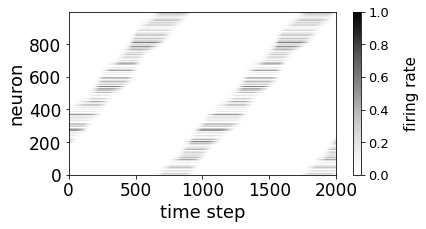

In [23]:
perc = 0
speed = 0
traj = 0
seed = 3
point = (perc, speed, traj, seed)
plot.activity_raster(raster[point]) #[:,:251])

### Figure 6f: Speed control works when neurons are silenced

In [26]:
speeds

array([ 1,  3,  5,  7,  9, 11, 13, 15])

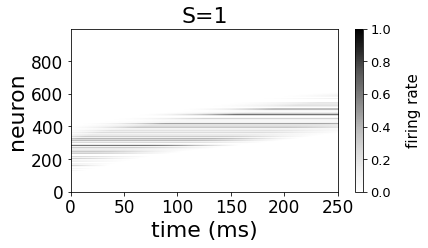

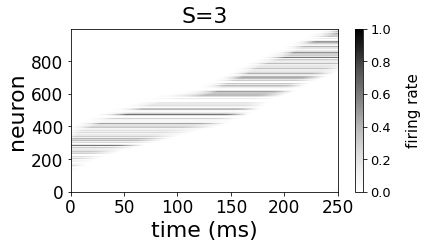

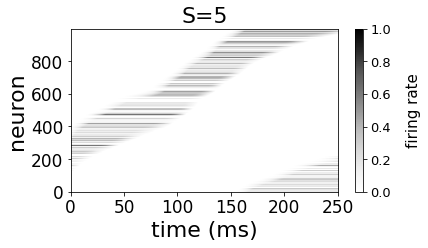

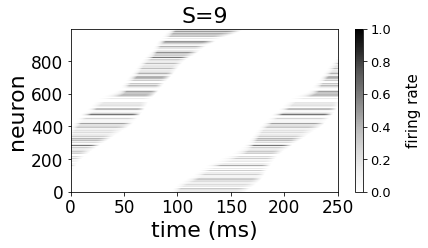

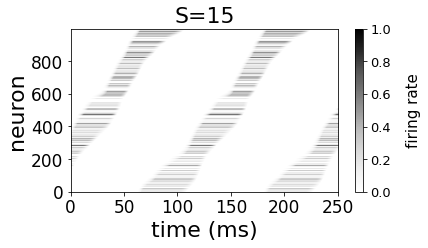

In [27]:
fname='raster_S='
speed_exs = [0,1,2,4,7]
perc = 0
traj = baseline_traj
seed = 0
for speed_i, speed in enumerate(speed_exs):
    point = (perc, speed, traj, seed)
    if save_figs_flag:
        file = fig_dir+fname+str(speeds[speed]+1)
        plot.activity_raster(raster[point][:,:251], xlabel='time (ms)', labelsize=22, title='S='+str(speeds[speed]), storage_loc=file)
    else:
         plot.activity_raster(raster[point][:,:251], xlabel='time (ms)', title='S='+str(speeds[speed]), labelsize=22)

### Method. Determing bump speed under selective inhibition

Smooth to "fill holes" so that speed detection works

In [24]:
act_tol = .01
sigma_bump_smoothing = 5

#### Example of smoothing to find bump center

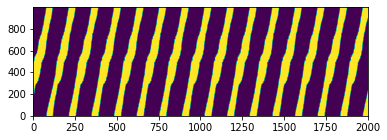

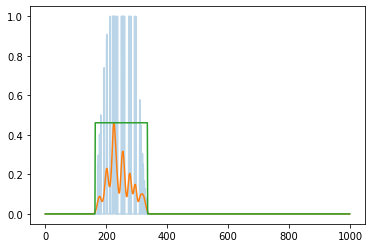

In [29]:
t_ex = 130
test_smoothing = gaussian_filter1d(raster[0,6,0,2], sigma=5, axis=0)
plt.figure(figsize=(6,2))
plt.imshow(test_smoothing > 0, origin='lower', aspect='auto')
plt.figure(figsize=(6,4))
plt.plot(raster[0,6,0,2][:, t_ex], alpha=0.3)
plt.plot(test_smoothing[:,t_ex])
plt.plot(np.max(test_smoothing[:,t_ex])*(test_smoothing[:,t_ex] > act_tol))
#plt.title(compute_bump_speed(test_smoothing > 0)[1])
plt.show()

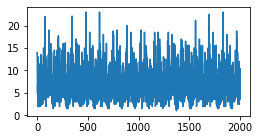

In [30]:
plt.figure(figsize=(4,2))
plt.plot(compute_bump_speed(test_smoothing, thr_act=act_tol)[1])

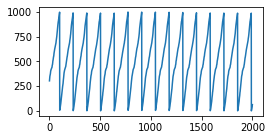

In [31]:
plt.figure(figsize=(4,2))
plt.plot(compute_bump_speed(test_smoothing, thr_act=act_tol)[0])

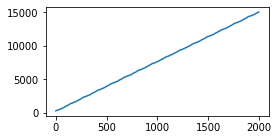

In [32]:
plt.figure(figsize=(4,2))
plt.plot(compute_bump_speed(test_smoothing, thr_act=act_tol)[2])

#### Find centers

In [25]:
centers = np.zeros((n_perc_sel, n_speeds, n_shapes, n_seeds, T))
pos_cumulative = np.zeros((n_perc_sel, n_speeds, n_shapes, n_seeds, T))
bump_speed = np.zeros((n_perc_sel, n_speeds, n_shapes, n_seeds, T-1))
for perc_i, perc in enumerate(perc_sel):
    for speed_i, speed in enumerate(speeds):
        for shape_i, shape in enumerate(shapes):
            for seed_i, seed in enumerate(seeds):
                point = (perc_i, speed_i, shape_i, seed_i)
                # compute bump center, speed, and cumulative position
                # smooth the bumps in space to remove the holes so that the bump centers are detected
                (centers[point][:], 
                 bump_speed[point][:], 
                 pos_cumulative[point][:]) = compute_bump_speed(gaussian_filter1d(raster[point], 
                                                                                  sigma=sigma_bump_smoothing, 
                                                                                  axis=0),
                                                               thr_act=act_tol)

### PCA

In [26]:
K = 6    # number of components
perc = 0 # index for perc inhibition, here 0 because only one p=0.8

In [27]:
joint_pca = defaultdict(dict)
raster_centered = defaultdict(dict)

for shape_i, shape in enumerate(shapes):
    for seed_i, seed in enumerate(seeds):
        joint_raster = np.zeros((N,1))
        for speed_i, speed in enumerate(speeds):
            point = (perc, speed_i, shape_i, seed_i)
            joint_raster = np.concatenate([joint_raster, raster[point]], axis=1)

        joint_raster = joint_raster[:,1:]
        joint_pca[shape_i, seed_i], _, raster_centered[shape_i, seed_i] = compute_pca(joint_raster, n_components=K)

In [28]:
speed = 0 # take baseline as speed=0 and no shape input, i.e. baseline_traj
pca_baseline = defaultdict(dict)
for seed_i, seed in enumerate(seeds):
    point = (perc, speed, baseline_traj, seed_i)
    pca_baseline[seed_i], _, raster_centered_ = compute_pca(raster[point], n_components=K)

### Rotations per second of trajectory

In [29]:
rotations = np.zeros((6, n_shapes, n_seeds, n_speeds))
for shape_i, shape in enumerate(shapes):
    for seed_i, seed in enumerate(seeds):
        basis = pca_baseline[seed_i].components_
        for i in range(n_speeds):
            prj = project_onto_basis(raster_centered[shape_i, seed_i][:,i*T: (i+1)*T], basis)
        
            analytic_signal = hilbert(prj)
            amplitude_envelope = np.abs(analytic_signal)
            instantaneous_phase = np.unwrap(np.angle(analytic_signal))
            
            rotations[:,shape_i, seed_i, i] = (instantaneous_phase[:,-1] - instantaneous_phase[:,0]) / (2*np.pi)

### Figure 6i: Plot trajectories for different speeds

In [30]:
prop_cycle = plt.rcParams['axes.prop_cycle']
speed_colors = prop_cycle.by_key()['color']

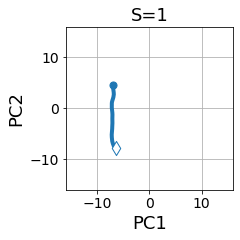

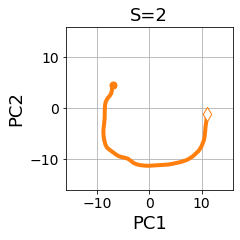

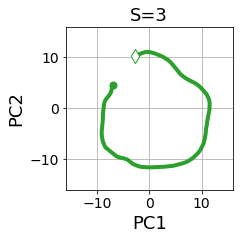

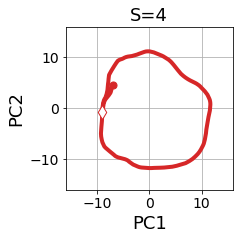

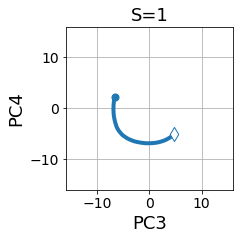

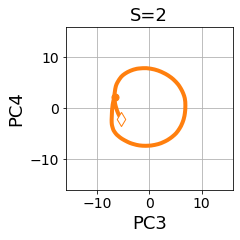

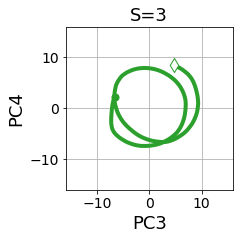

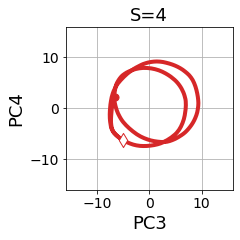

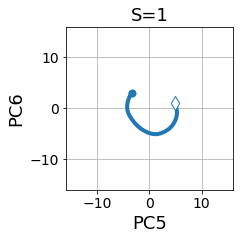

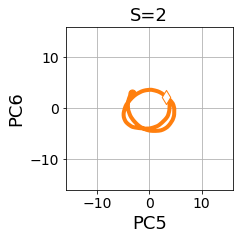

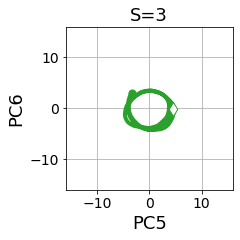

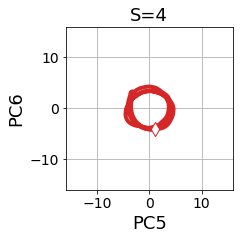

In [31]:
exs=[0,1,2,3]
shape_i = baseline_traj
seed_i = 3
basis = pca_baseline[seed_i].components_
for j in range(3):
    for i, ex_i in enumerate(exs):
        fname = 'pc_projection_k=' + str(j+1) + '_S=' + str(ex_i+1)
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        prj = project_onto_basis(raster_centered[shape_i, seed_i][:,ex_i*T:ex_i*T+250], basis)
        ax.plot(*prj[2*j:2*(j+1),:],linewidth=4, zorder=n_speeds - i, alpha=1, color=speed_colors[i])
        ax.scatter(*prj[2*j:2*(j+1),0], s=50, color=speed_colors[i])
        ax.scatter(*prj[2*j:2*(j+1),-1], marker='d', s=100, edgecolor=speed_colors[i], facecolor='white', zorder= 10+n_speeds - i)
        ax.set_xlim(-16,16)
        ax.set_ylim(-16,16)
        ax.set_axisbelow(True)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel('PC'+str(2*j+1), fontsize=18)
        ax.set_ylabel('PC'+str(2*(j+1)), fontsize=18)
        ax.set_title('S=' + str(ex_i+1), fontsize=18)
        ax.grid()
        if save_figs_flag:
            plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
            plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
        plt.show()

### Figure 6b: Plot the principal components

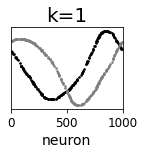

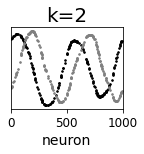

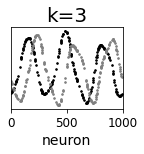

In [32]:
tol = 0.00001
black_gray = ['black', 'gray']
basis = pca_baseline[seed_i].components_
for j in range(3):
    fname = 'principal_components_k=' + str(j+1)
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    
    for i in range(2):
        non_zero_entries = np.where(np.abs(basis[2*j+i,:]) > tol)[0]
        ax.scatter(np.arange(N)[non_zero_entries],basis[2*j+i,non_zero_entries], color=black_gray[i], marker='.', s=10)
    ax.set_xticks([0,500,1000], [0,500,1000], fontsize=12)
    ax.set_xlabel('neuron', fontsize=14)
    ax.set_yticks([])
    ax.set_xlim(0,1000)
    ax.set_title('k='+str(j+1), fontsize=20)
    if save_figs_flag:
        plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
        plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
    plt.show()

### Figure 6h: Plot trajectory speed as a function of bump speed

In [33]:
# bump speed has form:
# (n_perc_sel, n_speeds, n_shapes, n_seeds, T-1)
bump_speed.shape

(1, 8, 11, 5, 2000)

In [34]:
# rotations has form:
# (n_pcs, n_shapes, n_seeds, n_speeds)
rotations.shape

(6, 11, 5, 8)

In [35]:
# average bump speed over time and seeds
bump_speed_mean = bump_speed[0,:,baseline_traj,:,:].mean(axis=(1,2))

# standard deviation of bump speed over trials
bump_speed_time_average = bump_speed[0,:,baseline_traj,:,:].mean(axis=2)
bump_speed_std = np.std(bump_speed_time_average, axis=1)

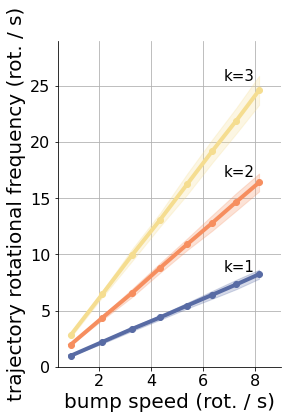

In [36]:
fname = 'trajectory_rot_freq_vs_bump_freq'
fig, ax = plt.subplots(figsize=(4,6))

# for the first three planes k=1,2,3 from pairs of first six PCs
for i in range(3):
    # first take the average of rotations in the two PCs spanning the plane
    rot_avg_over_pcs = rotations[(2*i):(2*(i+1)),baseline_traj,:,:].mean(axis=0)
    
    # compute mean and standard devations over seeds, divide by total number 
    # of seconds (T ms * 1s / 1000ms = T/1000)
    rot_mean = rot_avg_over_pcs.mean(axis=0).T / (T/1000)
    rot_std = rot_avg_over_pcs.std(axis=0).T / (T/1000)

    # plot rotations as function of bump speed
    # fill between mean +/- SD
    ax.plot(bump_speed_mean, rot_mean, color=colors[i], linewidth=4, marker='o')
    ax.fill_between(bump_speed_mean, 
                    rot_mean - rot_std, 
                    rot_mean + rot_std, 
                    color=colors[i], alpha=0.25)

    # add the mode k=1,2,3 as text
    ax.text(x=6.8,y=rotations[2*i,baseline_traj,0,-1]/(T/1000), s='k=' + str(i+1), fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.arange(0,16,2))
ax.set_xticklabels(np.arange(0,16,2), fontsize=16)
ax.set_yticks(np.arange(0,50,5).round(1))
ax.set_yticklabels(np.arange(0,50,5).round(1), fontsize=16)
ax.set_xlabel('bump speed (rot. / s)', fontsize=20)
ax.set_ylabel('trajectory rotational frequency (rot. / s)', fontsize=20)

ax.set_xlim(0.4,9)
ax.set_ylim(0,29)
ax.set_axisbelow(True)
ax.grid()

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()

### Figure 6g: Bump speed as a function of gain

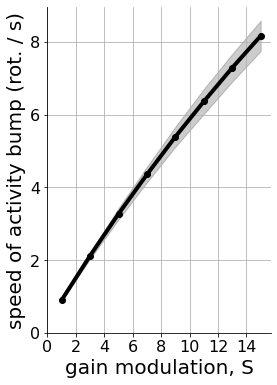

In [37]:
fname='bump_speed'
fig, ax = plt.subplots(1,1, figsize=(4,6))

ax.plot(speeds, bump_speed_mean, color='black',linewidth=4, marker='o')
ax.fill_between(speeds,
                bump_speed_mean - bump_speed_std, 
                bump_speed_mean + bump_speed_std, 
                color='black', alpha=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.arange(0,16,2))
ax.set_xticklabels(np.arange(0,16,2), fontsize=16)
ax.set_yticks(np.arange(0,10,2).round(1))
ax.set_yticklabels(np.arange(0,10,2).round(1), fontsize=16)
ax.set_xlabel('gain modulation, S', fontsize=20)
ax.set_ylabel('speed of activity bump (rot. / s)', fontsize=20)
ax.grid()

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()


### Shaping trajectories works for silencing

In [38]:
colors_seismic = plt.cm.seismic(np.linspace(0,1,n_shapes+1))

#### Compute PCA

In [39]:
# compute pca on each trial
basis_exs = defaultdict(dict)
trajectory = defaultdict(dict)
raster_centered_ex = np.zeros((n_seeds, n_shapes, n_speeds, N, T))
for speed_i, speed in enumerate(speeds):
    for subspace_i, subspace in enumerate(seeds):        
        for shape_i, shape in enumerate(shapes):
            point = (perc, speed_i, shape_i, subspace_i)
            (basis_exs[subspace_i, shape_i, speed_i], 
            trajectory[subspace_i, shape_i, speed_i], 
            raster_centered_ex[subspace_i, shape_i, speed_i]) = compute_pca(raster[point], 
                                                                            n_components=K, 
                                                                            compute_trajectory=True)

#### Figure 6m: Plot projections into subspaces

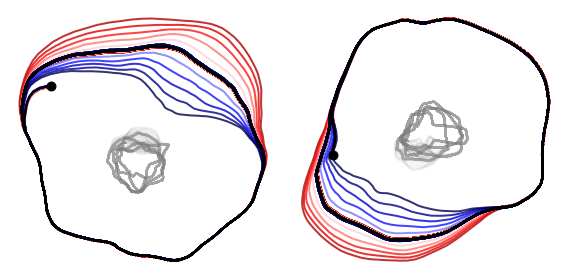

In [40]:
fname = 'projection_into_pc_space_k=1'
fig, ax = plt.subplots(1,2, figsize=(8,4))
speed_ex = 5
seed_exs = [2,3]
no_shape_input = np.where(shapes==0)[0][0]
for k_i, k in enumerate(seed_exs):
    for i in range(n_shapes):
        prj = project_onto_basis(raster_centered_ex[k,i,speed_ex], basis_exs[k,no_shape_input,speed_ex].components_)
        ax[k_i].plot(*prj[:2,:],linewidth=2, zorder=n_shapes-i, alpha=0.8, color=colors_seismic[i])
        for j in range(n_seeds):
            if j != k:
                prj = project_onto_basis(raster_centered_ex[j,i,speed_ex], basis_exs[k,no_shape_input,speed_ex].components_)
                ax[k_i].plot(*prj[:2,:],linewidth=2, zorder=n_shapes-i, alpha=0.1, color='grey')
    prj = project_onto_basis(raster_centered_ex[k,no_shape_input,speed_ex], basis_exs[k,no_shape_input,speed_ex].components_)
    ax[k_i].plot(*prj[:2,:],linewidth=2, zorder=100, alpha=1, color='black')
    ax[k_i].scatter(*prj[:2,0], zorder=110, alpha=1, color='black', s=80)

    ax[k_i].tick_params(axis='both', which='major', labelsize=14)
    ax[k_i].spines[:].set_visible(False)
    ax[k_i].set_xticks([])
    ax[k_i].set_yticks([])

fig.tight_layout()
if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()

#### Compute projection radius

In [41]:
prj_rad = np.zeros((3, n_seeds, n_shapes, n_speeds, 251))

for seed_i, seed in enumerate(seeds):
    for shape_i, shape in enumerate(shapes):
        for speed_i, speed in enumerate(speeds):
            for j in range(3):
                prj_rad[j, seed_i, shape_i, speed_i, :] = np.sqrt(np.sum(trajectory[seed_i, shape_i, speed_i][2*j:2*(j+1), :251]**2, axis=0))

#### Compute bump widths

In [42]:
active_neurons.shape

(1, 8, 11, 5, 2001)

In [43]:
# min/max bump width relative to baseline 
# smooth to get rid of holes, sigma for bump smoothing 
# count active neurons, above act_tol
# find index of maximum deflection

p_ex = 0
active_neurons_filt = np.zeros((n_seeds, n_speeds, n_shapes, T))
bump_widths_filt = np.zeros((n_seeds, n_speeds, n_shapes))
for seed_i, seed in enumerate(seeds):
    for speed_i, speed in enumerate(speeds):
        for shape_i in range(n_shapes):
            # get active region (smooth away holes)
            active_neurons_filt[seed_i, speed_i, shape_i,:] = np.sum(gaussian_filter1d(raster[p_ex,speed_i,shape_i,seed_i,:,:], 
                                                                                       sigma=sigma_bump_smoothing, axis=0) > act_tol,
                                                                     axis=0)

        # index of max deflection
        ind_diff_filt = np.argmax(np.abs(active_neurons_filt[seed_i, speed_i, baseline_traj, :] - 
                                         active_neurons_filt[seed_i, speed_i,:,:]), axis=1)
        
        # bump width at the min/max deflection
        bump_widths_filt[seed_i, speed_i, :] = active_neurons_filt[seed_i, speed_i, np.arange(n_shapes), ind_diff_filt]

#### Figure 6d: Radius of trajectory vs. bump width
Compute for time window at the time of peak input current

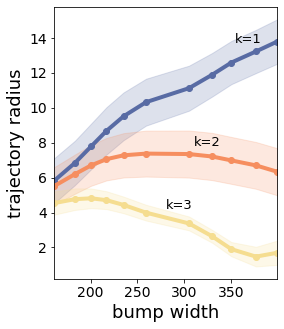

In [46]:
fname='trajectory_radius_vs_bump_width'
speed_i = 5
fig, ax = plt.subplots(1,1, figsize=(4,5))

# bump widths filt: n_seeds, n_speeds, n_shapes
# prj_rad: n_planes(k=1,2,3), n_seeds, n_shapes, n_speeds, n_timesteps

# time window
t1 = t_shape_input
t2 = t_shape_input + sd_shape_input

# average over seeds
bump_widths_filt_mean = bump_widths_filt[:, speed_i, :].mean(axis=0)

for i in range(3):
    # take average over seeds
    prj_rad_mean = prj_rad[i,:,:,speed_i, t1:t2].mean(axis=(0,2))
    prj_rad_std = prj_rad[i,:,:,speed_i, t1:t2].std(axis=(0,2))
    
    ax.plot(bump_widths_filt_mean, 
            prj_rad_mean, 
            color=colors[i], linewidth=4, marker='o')
    ax.fill_between(bump_widths_filt_mean, 
                    prj_rad_mean - prj_rad_std,
                    prj_rad_mean + prj_rad_std,
                    #prj_rad[i,:,:,speed_i, bump_argextr].mean(axis=0) - prj_rad[i,:,:,speed_i, bump_argextr].std(axis=0), 
                    #prj_rad[i,:,:,speed_i, bump_argextr].mean(axis=0) + prj_rad[i,:,:,speed_i, bump_argextr].std(axis=0), 
                    color=colors[i], alpha=0.2)

ax.set_xlim(np.min(bump_widths_filt_mean), np.max(bump_widths_filt_mean))
#ax.set_ylim(0,37)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('bump width', fontsize=18)
ax.set_ylabel('trajectory radius', fontsize=18)

ax.text(354,13.7, s='k=1',fontsize=13)
ax.text(310,7.8, s='k=2',fontsize=13)
ax.text(280,4.2, s='k=3',fontsize=13)

if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    #plt.savefig(fig_dir+fname + '.eps', bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()

#### Figure 6e

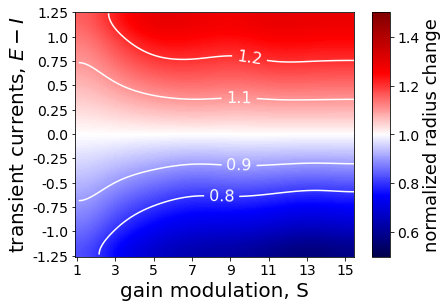

In [47]:
# prj_rad: n_planes(k=1,2,3), n_seeds, n_shapes, n_speeds, n_timesteps
# average over seeds and normalize to baseline

fname = 'trajectory_radius_as_function_of_shape_and_speed_input'

data = prj_rad[0,:,:,:, t1:t2].mean(axis=(0,3))/prj_rad[0,:,baseline_traj,:, t1:t2].mean(axis=(0,2))

# smoothing and contours
sigma=.8
contours=[0.8,0.9,1.1,1.2]

fig, ax = plt.subplots(figsize=(5,4.5))

if sigma > 0:
    data = gaussian_filter(data, sigma)
    data = zoom(data, 10)
if contours:
    _cs2 = ax.contour(data, levels=contours, origin='lower', colors='white') #, extent=extent) 
    plt.clabel(_cs2, inline=1, fontsize=16)


im = plt.imshow(data,cmap='seismic',
          vmin=0.5,vmax=1.5, origin='lower', aspect='auto')
plt.xticks(np.arange(n_speeds)*11, speeds, fontsize=14)
plt.yticks(np.arange(n_shapes)*11, shapes, fontsize=14)
plt.xlabel('gain modulation, S', fontsize=20)
plt.ylabel('transient currents, $E-I$', fontsize=20)

cax = fig.add_axes([ax.get_position().x1+0.05,
                    ax.get_position().y0,
                    0.05,
                    ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='normalized radius change',size=18)

cbar.ax.tick_params(labelsize=14)
if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")

plt.show()

#### Figure 6c

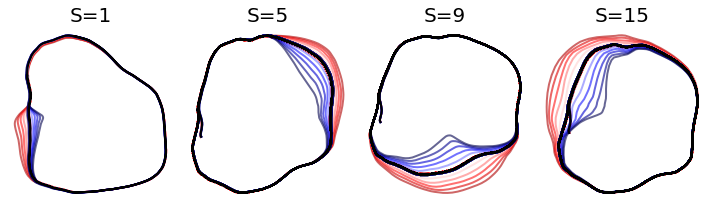

In [48]:
fname = 'projection_across_speeds_into_pc_space_k=1'
fig, ax = plt.subplots(1,4, figsize=(10,3))
speed_exs = [0,2,4,7]
seed_exs = [3]
no_shape_input = np.where(shapes==0)[0][0]
for speed_ex, speed in enumerate(speed_exs):
    for k_i, k in enumerate(seed_exs):
        for i in range(n_shapes):
            prj = project_onto_basis(raster_centered_ex[k,i,speed], basis_exs[k,no_shape_input,speed].components_)
            ax[speed_ex].plot(*prj[:2,:],linewidth=2, zorder=n_shapes-i, alpha=0.6, color=colors_seismic[i])
        prj = project_onto_basis(raster_centered_ex[k,no_shape_input,speed], basis_exs[k,no_shape_input,speed].components_)
        ax[speed_ex].plot(*prj[:2,:],linewidth=2, zorder=100, alpha=1, color='black')
    
        ax[speed_ex].tick_params(axis='both', which='major', labelsize=14)
        ax[speed_ex].spines[:].set_visible(False)
        ax[speed_ex].set_xticks([])
        ax[speed_ex].set_yticks([])
    ax[speed_ex].set_title('S=' + str(speeds[speed]), fontsize=20)

fig.tight_layout()
if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()

In [6]:
colors_seismic = plt.cm.seismic(np.linspace(0,1,n_shapes+1))

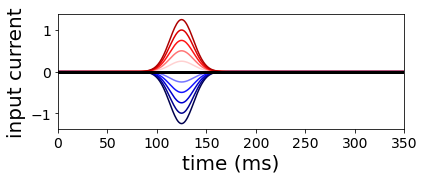

In [13]:
fname = 'fig6_EI_inputs'
fig, ax = plt.subplots(1,1, figsize=(6,2.5))

for i, A in enumerate(shapes):
    I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input)
    plt.plot(I_ext, color=colors_seismic[i])

plt.plot(gaussian(np.arange(T), shapes[5], t_shape_input, sd_shape_input), color='black', linewidth=3)

plt.xlim(250,750)
plt.xlabel('time (ms)', fontsize=20)
plt.ylabel('input current', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(0,350)

fig.tight_layout()
if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()